In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 54.7 MB/s eta 0:00:00


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split

# TRX-USD

In [7]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv('/content/drive/MyDrive/HK6_2022-2023/IS403.N22.HTCL - Phân tích dữ liệu kinh doanh/IS403_Team15/Project/Dataset/TRX-USD.csv')

# Xử lý dữ liệu
df = df[['Date', 'Close', 'Volume']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna().reset_index(drop=True)

## Tỉ lệ 7:2:1

In [8]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [9]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous


In [10]:
# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train, exogenous=exog_train, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình
model.fit(y_train, exogenous=exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10799.776, Time=4.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10804.672, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10803.055, Time=0.99 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10802.932, Time=1.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10806.438, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-10801.031, Time=1.58 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 10.018 seconds


In [12]:
# Kiểm tra trên tập test
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred = model.predict(n_periods=len(y_test), exogenous=exog_test)

# Kiểm tra trên tập validate
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
exog_val = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val = model.predict(n_periods=len(y_val), exogenous=exog_val)

In [13]:
# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính toán RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.03333051823850333
Validation RMSE: 0.03413849942542834
Validation MAPE: 54.29882525536347
Testing MAE: 0.02688394863130731
Testing RMSE: 0.029174545099743824
Testing MAPE: 41.36501393749239


In [ ]:
# # Tạo index dự đoán cho 30 ngày tiếp theo
# last_index = df.index[-1]
# x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)
# y_next_30_days = model.predict(n_periods=len(x_next_30_days), exogenous=x_next_30_days)

# # In ra kết quả dự đoán 30 ngày
# print('Predicted closing prices for the next 30 days:')
# for i in range(len(y_next_30_days)):
#     print(f'Day {i+1}: {y_next_30_days[i]}')


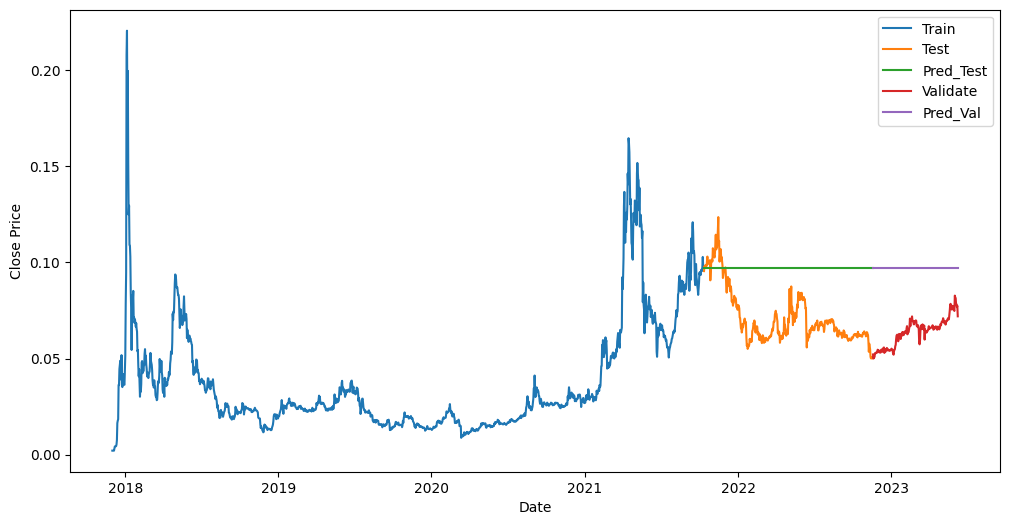

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Train')
plt.plot(test_data['Date'], test_data['Close'], label='Test')
plt.plot(test_data['Date'], y_pred, label='Pred_Test')
plt.plot(val_data['Date'], val_data['Close'], label='Validate')
plt.plot(val_data['Date'], y_pred_val, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
test_data.index

RangeIndex(start=1646, stop=2116, step=1)

## Tỉ lệ 5:3:2

In [15]:
# Chia train, test, validate theo tỉ lệ 5:3:2
train_size1 = int(0.5 * len(df))
test_size1 = int(0.3 * len(df))
val_size1 = len(df) - train_size1 - test_size1

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

In [16]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train1 = np.array(train_data1.index).reshape(-1, 1)
y_train1 = np.array(train_data1['Close'])
exog_train1 = np.array(train_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train1, exogenous=exog_train1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit mô hình
model.fit(y_train1, exogenous=exog_train1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7804.328, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7749.881, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7753.469, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7753.165, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7751.823, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7808.144, Time=1.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7747.564, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7745.880, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7872.431, Time=0.93 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7850.662, Time=1.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-7880.762, Time=2.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-7880.316, Time=3.33 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-7886.439, Time=1.61 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-7888.373, Time=1.42 sec
 ARIMA(0,1,4)(0,0,0

ARIMA(order=(1, 1, 5), scoring_args={}, suppress_warnings=True)

In [17]:
# Kiểm tra trên tập test
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1['Close'])
exog_test1 = np.array(test_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred1 = model.predict(n_periods=len(y_test1), exogenous=exog_test1)

# Kiểm tra trên tập validate
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1['Close'])
exog_val1 = np.array(val_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val1 = model.predict(n_periods=len(y_val1), exogenous=exog_val1)


In [ ]:
# # Tạo index dự đoán cho 30 ngày tiếp theo
# last_index1 = df.index[-1]
# x_next1_30_days = np.array(range(last_index1 + 1, last_index1 + 31)).reshape(-1, 1)
# y_next1_30_days = model.predict(n_periods=len(x_next1_30_days), exogenous=x_next1_30_days)

# # In ra kết quả dự đoán 30 ngày
# print('Predicted closing prices for the next 30 days:')
# for i in range(len(y_next1_30_days)):
#     print(f'Day {i+1}: {y_next1_30_days[i]}')

In [18]:
# Tính MAE
valid_mae1 = mean_absolute_error(y_val1, y_pred_val1)
test_mae1 = mean_absolute_error(y_test1, y_pred1)

# Tính toán RMSE
valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - y_val1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - y_test1)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred1):
    return np.mean(np.abs((y_true - y_pred1) / y_true)) * 100

valid_mape1 = mean_absolute_percentage_error(y_val1, y_pred_val1)
test_mape1 = mean_absolute_percentage_error(y_test1, y_pred1)

print('Validation MAE:', valid_mae1)
print('Validation RMSE:', valid_rmse1)
print('Validation MAPE:', valid_mape1)
print('Testing MAE:', test_mae1)
print('Testing RMSE:', test_rmse1)
print('Testing MAPE:', test_mape1)

Validation MAE: 0.01740492206864005
Validation RMSE: 0.01961323551810967
Validation MAPE: 25.641875436145618
Testing MAE: 0.023177544763022237
Testing RMSE: 0.03194237673578885
Testing MAPE: 33.77756626182164


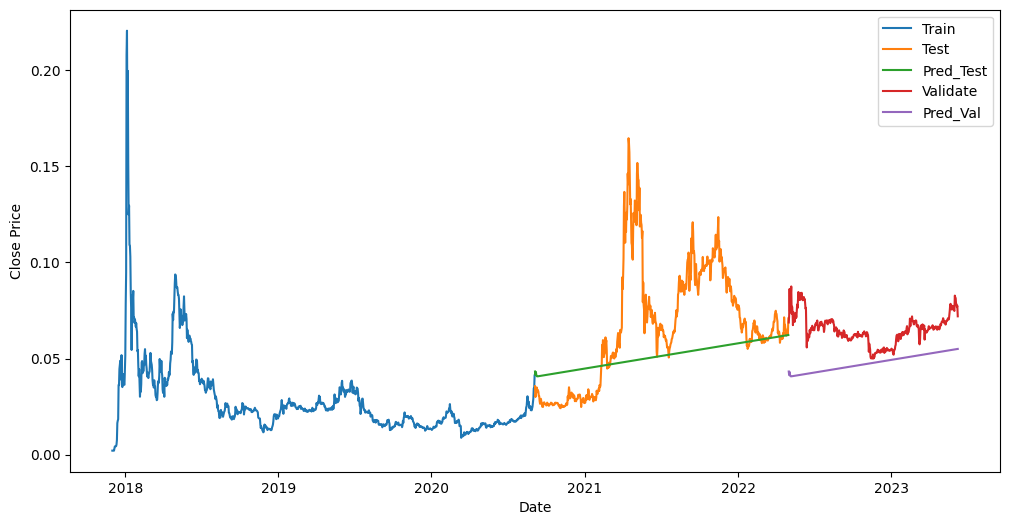

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(train_data1['Date'], train_data1['Close'], label='Train')
plt.plot(test_data1['Date'], test_data1['Close'], label='Test')
plt.plot(test_data1['Date'], y_pred1, label='Pred_Test')
plt.plot(val_data1['Date'], val_data1['Close'], label='Validate')
plt.plot(val_data1['Date'], y_pred_val1, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
test_data.index

RangeIndex(start=1646, stop=2116, step=1)

# DOGE-USD

In [21]:
# Đọc dữ liệu từ file CSV
df1 = pd.read_csv('/content/drive/MyDrive/HK6_2022-2023/IS403.N22.HTCL - Phân tích dữ liệu kinh doanh/IS403_Team15/Project/Dataset/DOGE-USD.csv')

# Xử lý dữ liệu
df1 = df1[['Date', 'Close', 'Volume']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df1['Date'] = pd.to_datetime(df['Date'])
df1 = df1.dropna().reset_index(drop=True)

## Tỉ lệ 7:2:1

In [22]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [23]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous


In [28]:
# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train, exogenous=exog_train, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình
model.fit(y_train, exogenous=exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-8187.891, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8161.669, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8182.490, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8178.693, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8163.460, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-8211.213, Time=1.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-8199.423, Time=0.69 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8183.319, Time=0.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-8235.037, Time=2.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-8237.062, Time=3.14 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-8235.027, Time=1.33 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-8239.603, Time=2.23 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-8270.552, Time=2.50 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-8269.645, Time=2.00 sec
 ARIMA(3,1,4)(0,0,0

ARIMA(order=(5, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [29]:
# Kiểm tra trên tập test
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred = model.predict(n_periods=len(y_test), exogenous=exog_test)

# Kiểm tra trên tập validate
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
exog_val = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val = model.predict(n_periods=len(y_val), exogenous=exog_val)

In [30]:
# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính toán RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.15280945584384223
Validation RMSE: 0.1530625030339307
Validation MAPE: 192.46193948104238
Testing MAE: 0.11406471719226087
Testing RMSE: 0.12560851169220646
Testing MAPE: 137.83206383802792


In [ ]:
# # Tạo index dự đoán cho 30 ngày tiếp theo
# last_index = df.index[-1]
# x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)
# y_next_30_days = model.predict(n_periods=len(x_next_30_days), exogenous=x_next_30_days)

# # In ra kết quả dự đoán 30 ngày
# print('Predicted closing prices for the next 30 days:')
# for i in range(len(y_next_30_days)):
#     print(f'Day {i+1}: {y_next_30_days[i]}')


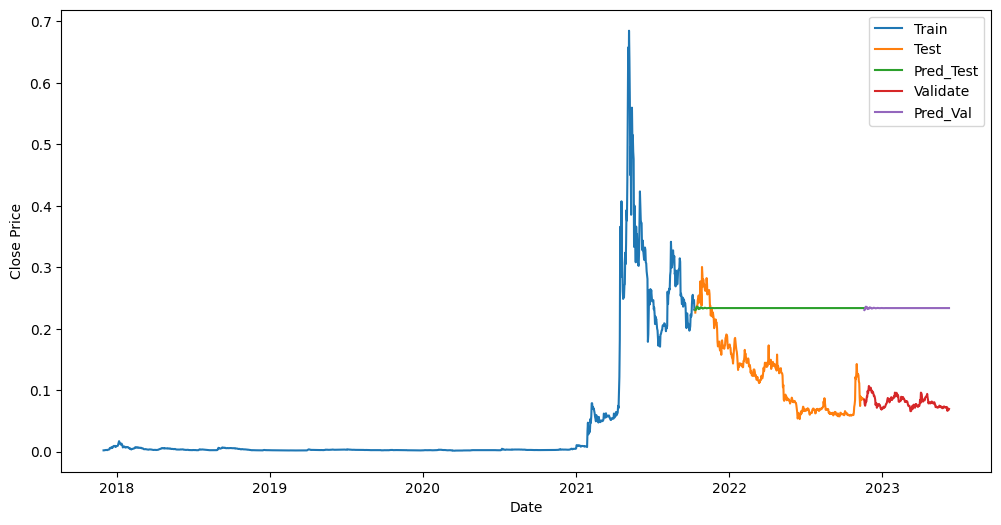

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Train')
plt.plot(test_data['Date'], test_data['Close'], label='Test')
plt.plot(test_data['Date'], y_pred, label='Pred_Test')
plt.plot(val_data['Date'], val_data['Close'], label='Validate')
plt.plot(val_data['Date'], y_pred_val, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
test_data.index

RangeIndex(start=1646, stop=2116, step=1)

## Tỉ lệ 5:3:2

In [ ]:
# Chia train, test, validate theo tỉ lệ 5:3:2
train_size1 = int(0.5 * len(df))
test_size1 = int(0.3 * len(df))
val_size1 = len(df) - train_size1 - test_size1

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

In [ ]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train1 = np.array(train_data1.index).reshape(-1, 1)
y_train1 = np.array(train_data1['Close'])
exog_train1 = np.array(train_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train1, exogenous=exog_train1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit mô hình
model.fit(y_train1, exogenous=exog_train1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7804.328, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7749.881, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7753.469, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7753.165, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7751.823, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7808.144, Time=1.32 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7747.564, Time=0.59 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7745.880, Time=0.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7872.431, Time=0.93 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7850.662, Time=1.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-7880.762, Time=2.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-7880.316, Time=3.33 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-7886.439, Time=1.61 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-7888.373, Time=1.42 sec
 ARIMA(0,1,4)(0,0,0

ARIMA(order=(1, 1, 5), scoring_args={}, suppress_warnings=True)

In [ ]:
# Kiểm tra trên tập test
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1['Close'])
exog_test1 = np.array(test_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred1 = model.predict(n_periods=len(y_test1), exogenous=exog_test1)

# Kiểm tra trên tập validate
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1['Close'])
exog_val1 = np.array(val_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val1 = model.predict(n_periods=len(y_val1), exogenous=exog_val1)


In [ ]:
# # Tạo index dự đoán cho 30 ngày tiếp theo
# last_index1 = df.index[-1]
# x_next1_30_days = np.array(range(last_index1 + 1, last_index1 + 31)).reshape(-1, 1)
# y_next1_30_days = model.predict(n_periods=len(x_next1_30_days), exogenous=x_next1_30_days)

# # In ra kết quả dự đoán 30 ngày
# print('Predicted closing prices for the next 30 days:')
# for i in range(len(y_next1_30_days)):
#     print(f'Day {i+1}: {y_next1_30_days[i]}')

In [ ]:
# Tính MAE
valid_mae1 = mean_absolute_error(y_val1, y_pred_val1)
test_mae1 = mean_absolute_error(y_test1, y_pred1)

# Tính toán RMSE
valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - y_val1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - y_test1)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred1):
    return np.mean(np.abs((y_true - y_pred1) / y_true)) * 100

valid_mape1 = mean_absolute_percentage_error(y_val1, y_pred_val1)
test_mape1 = mean_absolute_percentage_error(y_test1, y_pred1)

print('Validation MAE:', valid_mae1)
print('Validation RMSE:', valid_rmse1)
print('Validation MAPE:', valid_mape1)
print('Testing MAE:', test_mae1)
print('Testing RMSE:', test_rmse1)
print('Testing MAPE:', test_mape1)

Validation MAE: 0.01740492206864005
Validation RMSE: 0.01961323551810967
Validation MAPE: 25.641875436145618
Testing MAE: 0.023177544763022237
Testing RMSE: 0.03194237673578885
Testing MAPE: 33.77756626182164


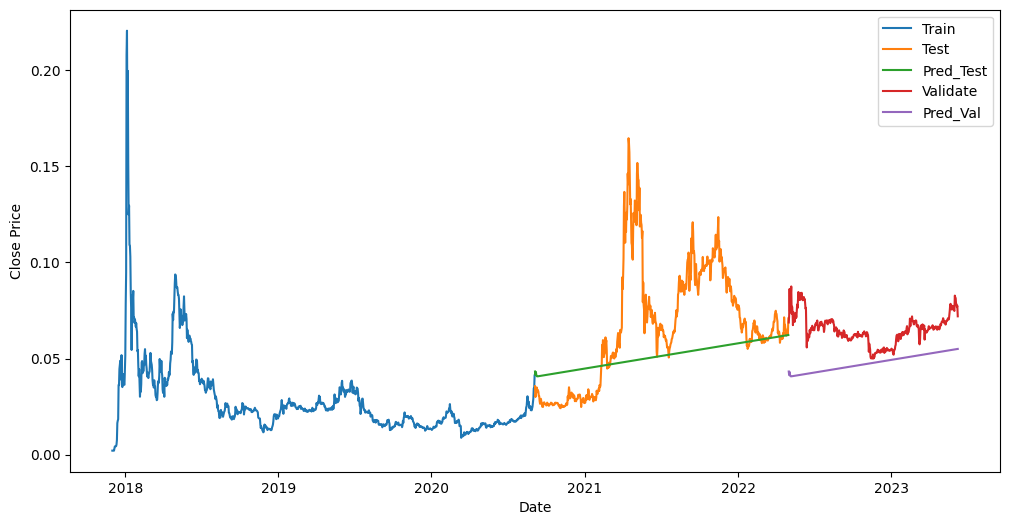

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(train_data1['Date'], train_data1['Close'], label='Train')
plt.plot(test_data1['Date'], test_data1['Close'], label='Test')
plt.plot(test_data1['Date'], y_pred1, label='Pred_Test')
plt.plot(val_data1['Date'], val_data1['Close'], label='Validate')
plt.plot(val_data1['Date'], y_pred_val1, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
test_data.index

RangeIndex(start=1646, stop=2116, step=1)

# XRP-USD

In [31]:
# Đọc dữ liệu từ file CSV
df2 = pd.read_csv('/content/drive/MyDrive/HK6_2022-2023/IS403.N22.HTCL - Phân tích dữ liệu kinh doanh/IS403_Team15/Project/Dataset/XRP-USD.csv')

# Xử lý dữ liệu
df2 = df2[['Date', 'Close', 'Volume']]  # Chỉ lấy cột 'Date', 'Close' và 'Volume'
df2['Date'] = pd.to_datetime(df2['Date'])
df2 = df2.dropna().reset_index(drop=True)

## Tỉ lệ 7:2:1

In [32]:
# Chia train, test, validate theo tỉ lệ 7:2:1
train_size = int(0.7 * len(df2))
test_size = int(0.2 * len(df2))
val_size = len(df2) - train_size - test_size

train_data = df2[:train_size]
test_data = df2[train_size:train_size+test_size]
val_data = df2[train_size+test_size:]

In [33]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])
exog_train = np.array(train_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous


In [34]:
# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train, exogenous=exog_train, trace=True, error_action='ignore', suppress_warnings=True)
# Fit mô hình
model.fit(y_train, exogenous=exog_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-3766.853, Time=2.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3767.257, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3766.162, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3766.093, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3769.120, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3764.126, Time=0.22 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.535 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [35]:
# Kiểm tra trên tập test
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
exog_test = np.array(test_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred = model.predict(n_periods=len(y_test), exogenous=exog_test)

# Kiểm tra trên tập validate
x_val = np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
exog_val = np.array(val_data['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val = model.predict(n_periods=len(y_val), exogenous=exog_val)

In [36]:
# Tính MAE
valid_mae = mean_absolute_error(y_val, y_pred_val)
test_mae = mean_absolute_error(y_test, y_pred)

# Tính toán RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
test_mape = mean_absolute_percentage_error(y_test, y_pred)

print('Validation MAE:', valid_mae)
print('Validation RMSE:', valid_rmse)
print('Validation MAPE:', valid_mape)
print('Testing MAE:', test_mae)
print('Testing RMSE:', test_rmse)
print('Testing MAPE:', test_mape)

Validation MAE: 0.7170062057784038
Validation RMSE: 0.7192476158471763
Validation MAPE: 175.0625179139237
Testing MAE: 0.5135748962462688
Testing RMSE: 0.5725283886838894
Testing MAPE: 115.18930490427923


In [ ]:
# # Tạo index dự đoán cho 30 ngày tiếp theo
# last_index = df.index[-1]
# x_next_30_days = np.array(range(last_index + 1, last_index + 31)).reshape(-1, 1)
# y_next_30_days = model.predict(n_periods=len(x_next_30_days), exogenous=x_next_30_days)

# # In ra kết quả dự đoán 30 ngày
# print('Predicted closing prices for the next 30 days:')
# for i in range(len(y_next_30_days)):
#     print(f'Day {i+1}: {y_next_30_days[i]}')


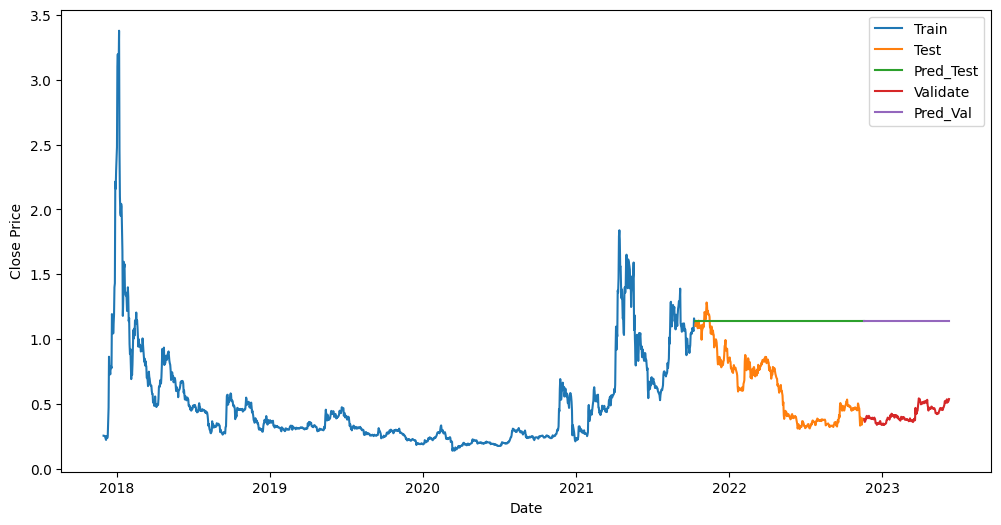

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(train_data['Date'], train_data['Close'], label='Train')
plt.plot(test_data['Date'], test_data['Close'], label='Test')
plt.plot(test_data['Date'], y_pred, label='Pred_Test')
plt.plot(val_data['Date'], val_data['Close'], label='Validate')
plt.plot(val_data['Date'], y_pred_val, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
test_data.index

RangeIndex(start=1646, stop=2116, step=1)

## Tỉ lệ 5:3:2

In [38]:
# Chia train, test, validate theo tỉ lệ 5:3:2
train_size1 = int(0.5 * len(df))
test_size1 = int(0.3 * len(df))
val_size1 = len(df) - train_size1 - test_size1

train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]

In [39]:
# Tiến hành huấn luyện mô hình ARIMAX
x_train1 = np.array(train_data1.index).reshape(-1, 1)
y_train1 = np.array(train_data1['Close'])
exog_train1 = np.array(train_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous

# Tìm mô hình ARIMAX tốt nhất bằng cách sử dụng auto_arima
model = auto_arima(y_train1, exogenous=exog_train1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit mô hình
model.fit(y_train1, exogenous=exog_train1)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-7804.328, Time=2.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7749.881, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7753.469, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7753.165, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7751.823, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-7808.144, Time=1.95 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-7747.564, Time=0.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7745.880, Time=0.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-7872.431, Time=0.92 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-7850.662, Time=1.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-7880.762, Time=1.53 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-7880.316, Time=1.77 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-7886.439, Time=1.14 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-7888.373, Time=1.36 sec
 ARIMA(0,1,4)(0,0,0

ARIMA(order=(1, 1, 5), scoring_args={}, suppress_warnings=True)

In [40]:
# Kiểm tra trên tập test
x_test1 = np.array(test_data1.index).reshape(-1, 1)
y_test1 = np.array(test_data1['Close'])
exog_test1 = np.array(test_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred1 = model.predict(n_periods=len(y_test1), exogenous=exog_test1)

# Kiểm tra trên tập validate
x_val1 = np.array(val_data1.index).reshape(-1, 1)
y_val1 = np.array(val_data1['Close'])
exog_val1 = np.array(val_data1['Volume']).reshape(-1, 1)  # Sử dụng cột 'Volume' làm biến exogenous
y_pred_val1 = model.predict(n_periods=len(y_val1), exogenous=exog_val1)


In [ ]:
# # Tạo index dự đoán cho 30 ngày tiếp theo
# last_index1 = df.index[-1]
# x_next1_30_days = np.array(range(last_index1 + 1, last_index1 + 31)).reshape(-1, 1)
# y_next1_30_days = model.predict(n_periods=len(x_next1_30_days), exogenous=x_next1_30_days)

# # In ra kết quả dự đoán 30 ngày
# print('Predicted closing prices for the next 30 days:')
# for i in range(len(y_next1_30_days)):
#     print(f'Day {i+1}: {y_next1_30_days[i]}')

In [41]:
# Tính MAE
valid_mae1 = mean_absolute_error(y_val1, y_pred_val1)
test_mae1 = mean_absolute_error(y_test1, y_pred1)

# Tính toán RMSE
valid_rmse1 = np.sqrt(np.mean((y_pred_val1 - y_val1)**2))
test_rmse1 = np.sqrt(np.mean((y_pred1 - y_test1)**2))

# Tính MAPE
def mean_absolute_percentage_error(y_true, y_pred1):
    return np.mean(np.abs((y_true - y_pred1) / y_true)) * 100

valid_mape1 = mean_absolute_percentage_error(y_val1, y_pred_val1)
test_mape1 = mean_absolute_percentage_error(y_test1, y_pred1)

print('Validation MAE:', valid_mae1)
print('Validation RMSE:', valid_rmse1)
print('Validation MAPE:', valid_mape1)
print('Testing MAE:', test_mae1)
print('Testing RMSE:', test_rmse1)
print('Testing MAPE:', test_mape1)

Validation MAE: 0.01740492206864005
Validation RMSE: 0.01961323551810967
Validation MAPE: 25.641875436145618
Testing MAE: 0.023177544763022237
Testing RMSE: 0.03194237673578885
Testing MAPE: 33.77756626182164


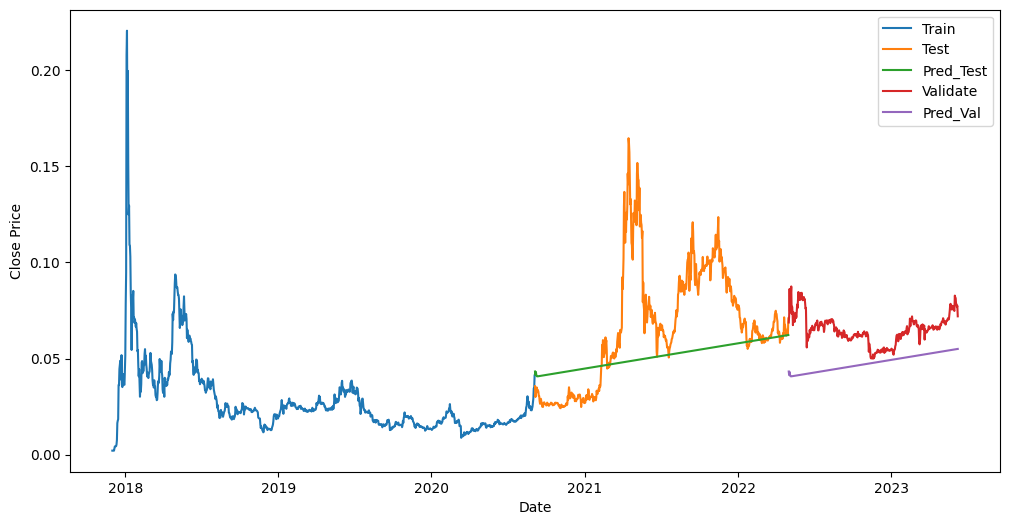

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(train_data1['Date'], train_data1['Close'], label='Train')
plt.plot(test_data1['Date'], test_data1['Close'], label='Test')
plt.plot(test_data1['Date'], y_pred1, label='Pred_Test')
plt.plot(val_data1['Date'], val_data1['Close'], label='Validate')
plt.plot(val_data1['Date'], y_pred_val1, label='Pred_Val')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [ ]:
test_data.index

RangeIndex(start=1646, stop=2116, step=1)